In [ ]:
# Implementar bigram model from Andrej Karpathy Tutorial
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [1]:
f = open('names.txt', 'r')

words = list(w.strip() for w in f.readlines())

In [2]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
# Generating int representation of characters
unique_chars = []
for w in words:
    for i in range(len(w)):
        unique_chars.append(w[i])

unique_chars = sorted(list(set(unique_chars)))

In [4]:
stoi = { c: i+1 for i,c in enumerate(unique_chars)}
stoi['.'] = 0 # Adding '.' character to denote start and end of a string

itos = { v:k  for k,v in stoi.items()}

In [5]:
import torch

N = torch.zeros(len(unique_chars)+1, len(unique_chars)+1)
N.shape

torch.Size([27, 27])

In [6]:
# Generating bigrams
for w in words:
    w = '.'+ w +'.'
    # print(w)
    
    for c1,c2 in zip(w, w[1:]):
        N[stoi[c1], stoi[c2]] += 1
        # print(c1, c2)

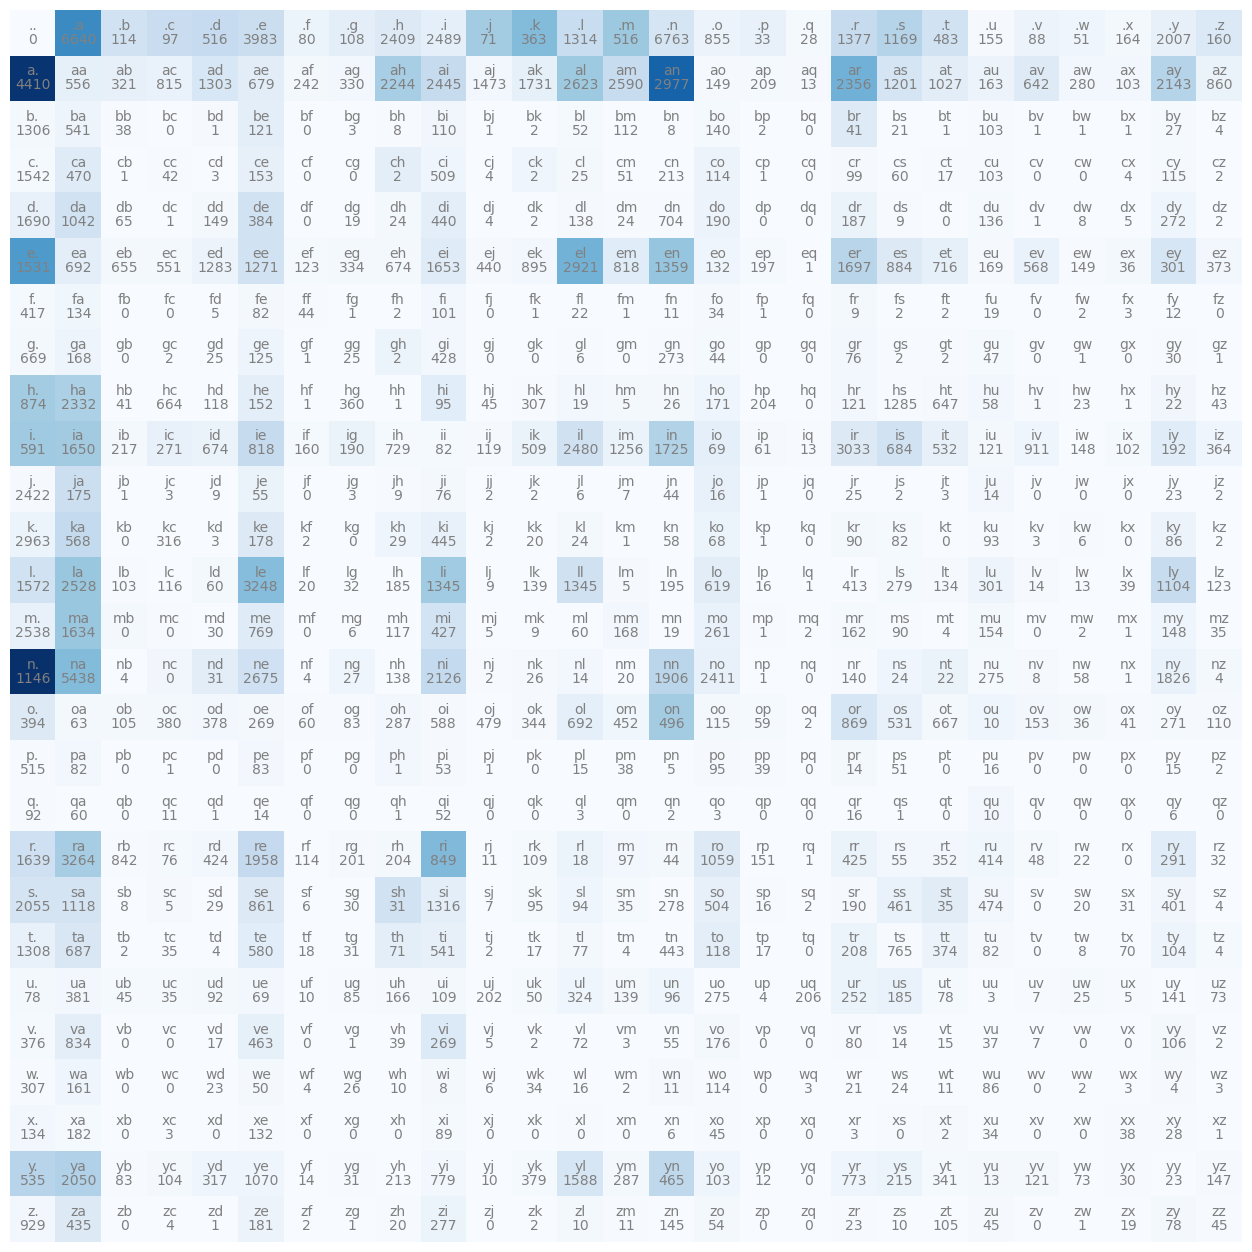

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, int(N[j,i].item()), ha="center", va="top", color='gray')
plt.axis('off');

In [8]:
P = N / N.sum(axis=1, keepdims=True)

In [9]:
# Generating random words according to probabilities
g = torch.Generator().manual_seed(1231231)

results = []
for i in range(10):
    ix = 0 # first character should be '.'
    w = itos[ix]
    while True:
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        w += itos[ix]
        if ix == 0:
            break
    
    results.append(w)
    print(w) # printing resulting words from statistical calculation...    

.bnel.
.dani.
.ozunighoni.
.kovan.
.frynik.
.jarimaravia.
.sona.
.sneyn.
.eei.
.obriiare.


In [10]:
# Calculating the negative log likelihood of each word
logprob = 0.0
for w in results:
    n = 0
    for c1,c2 in zip(w, w[1:]):
        logprob += torch.log(P[stoi[c1], stoi[c2]])
        n += 1
        
    print(f"Log Likelihood({w}): {logprob:.4f} / Avg. Log-Likelihood({w}): {logprob/n:.4f} / Negative Avg. Log-Likelihood:({w}): {-logprob/n:.4f}")

Log Likelihood(.bnel.): -16.4972 / Avg. Log-Likelihood(.bnel.): -3.2994 / Negative Avg. Log-Likelihood:(.bnel.): 3.2994
Log Likelihood(.dani.): -27.0330 / Avg. Log-Likelihood(.dani.): -5.4066 / Negative Avg. Log-Likelihood:(.dani.): 5.4066
Log Likelihood(.ozunighoni.): -58.9042 / Avg. Log-Likelihood(.ozunighoni.): -5.3549 / Negative Avg. Log-Likelihood:(.ozunighoni.): 5.3549
Log Likelihood(.kovan.): -71.9924 / Avg. Log-Likelihood(.kovan.): -11.9987 / Negative Avg. Log-Likelihood:(.kovan.): 11.9987
Log Likelihood(.frynik.): -91.5597 / Avg. Log-Likelihood(.frynik.): -13.0800 / Negative Avg. Log-Likelihood:(.frynik.): 13.0800
Log Likelihood(.jarimaravia.): -115.6346 / Avg. Log-Likelihood(.jarimaravia.): -9.6362 / Negative Avg. Log-Likelihood:(.jarimaravia.): 9.6362
Log Likelihood(.sona.): -125.7451 / Avg. Log-Likelihood(.sona.): -25.1490 / Negative Avg. Log-Likelihood:(.sona.): 25.1490
Log Likelihood(.sneyn.): -142.5392 / Avg. Log-Likelihood(.sneyn.): -23.7565 / Negative Avg. Log-Likeliho

### Neural Network Bigram model

In [11]:
from torch.functional import F

In [12]:
t_size = len(stoi.keys())
t_size

27

In [13]:
nn_words = ['.'+ w +'.' for w in words]

xs,ys = [],[]
for w in nn_words:
    for e1,e2 in zip(w,w[1:]):
        ix1 = torch.tensor(stoi[e1])
        ix2 = torch.tensor(stoi[e2])
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [14]:
xs.nelement()

228146

In [67]:
# Initializing random weights and learning rate
W = torch.randn((t_size, t_size), generator=g, requires_grad=True)
# W = W - W.min() / (W.max() - W.min()) # Applying individual normalization to entire dataset
W.shape

torch.Size([27, 27])

In [288]:
# Single Layer Neural Network
# Forward pass
lr = -20 # Learning rate
for n in range(100000):
    xenc = F.one_hot(xs, num_classes=t_size).float()
    logits = xenc @ W
    counts = logits.exp() 
    probs = counts/counts.sum(1, keepdims=True)
    
    loss = -probs[torch.arange(len(ys)), ys].log().mean() # Is it really negative average log likelihood?

    W.grad = None
    loss.backward()
    
    W.data += lr * W.grad
    break
    
print(f"Loss: {loss}")

Loss: 2.4696905612945557


In [290]:
for i in range(10):
    ix = 0
    w1 = itos[ix]
    while True:   
        # P counts 
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        w1 += itos[ix]
        if ix == 0: 
            break
        
        
    w2 = itos[ix]
    while True:
        # forward pass
        xenc = F.one_hot(torch.tensor([stoi[w2[-1]]]), num_classes=t_size).float()
        logits = xenc @ W
        probs = logits.exp()/logits.exp().sum(1, keepdims=True)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        w2 += itos[ix]
        if ix == 0: 
            break
    
    print(f"P: {w1.strip('.')}\nNN:{w2.strip('.')}")

P: kianen
NN:ceienn
P: an
NN:monanl
P: ma
NN:zann
P: waroppriajieyath
NN:be
P: astenauroc
NN:chans
P: riat
NN:alylisgh
P: ann
NN:tiak
P: tay
NN:jaban
P: ahai
NN:binantomita
P: jule
NN:sa


### Neural Network Trigram Model - Bengio,2003

In [291]:
stoi.items()

dict_items([('a', 1), ('b', 2), ('c', 3), ('d', 4), ('e', 5), ('f', 6), ('g', 7), ('h', 8), ('i', 9), ('j', 10), ('k', 11), ('l', 12), ('m', 13), ('n', 14), ('o', 15), ('p', 16), ('q', 17), ('r', 18), ('s', 19), ('t', 20), ('u', 21), ('v', 22), ('w', 23), ('x', 24), ('y', 25), ('z', 26), ('.', 0)])

In [292]:
block_size = 3
xs,ys = [],[]
for w in words[:5]:
    w += '.'
    char_seq = '.' * block_size
    for ch in w:
        xs.append(char_seq)
        ys.append(ch)
        char_seq += ch
        char_seq = char_seq[1:]
        print(f"{xs[-1]} ---> {ys[-1]}")
        
print(f"{xs=}")
print(f"{ys=}")

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .
xs=['...', '..e', '.em', 'emm', 'mma', '...', '..o', '.ol', 'oli', 'liv', 'ivi', 'via', '...', '..a', '.av', 'ava', '...', '..i', '.is', 'isa', 'sab', 'abe', 'bel', 'ell', 'lla', '...', '..s', '.so', 'sop', 'oph', 'phi', 'hia']
ys=['e', 'm', 'm', 'a', '.', 'o', 'l', 'i', 'v', 'i', 'a', '.', 'a', 'v', 'a', '.', 'i', 's', 'a', 'b', 'e', 'l', 'l', 'a', '.', 's', 'o', 'p', 'h', 'i', 'a', '.']


In [293]:
# Constructing Trigram dataset
block_size = 3
xs,ys = [],[]
for w in words:    
    w += '.' 
    char_seq = '.' * block_size
    for ch in w:        
        xs.append([stoi[el] for el in char_seq])
        ys.append(stoi[ch])
        
        char_seq += ch
        char_seq = char_seq[1:]
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [294]:
n1, n2 = round(0.8*len(xs)), round(0.9*len(xs))

xs_train, xs_dev, xs_test = xs[:n1], xs[n1:n2], xs[n2:]
ys_train, ys_dev, ys_test = ys[:n1], ys[n1:n2], ys[n2:]

In [295]:
xs_train.shape, xs_dev.shape, xs_test.shape

(torch.Size([182517, 3]), torch.Size([22814, 3]), torch.Size([22815, 3]))

In [296]:
ys_train.shape, ys_dev.shape, ys_test.shape

(torch.Size([182517]), torch.Size([22814]), torch.Size([22815]))

In [297]:
g = torch.Generator().manual_seed(201432192)

C = torch.randn(27,2, generator=g) # char embedding
W1 = torch.randn(6, 100, generator=g) # Hidden layer with activation function tanh
b1 = torch.randn(100, generator=g)

W2 = torch.randn(100, 27, generator=g) # Softmax layer
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

total = 0
for m in parameters:
    total += m.nelement()

for p in parameters:
    p.requires_grad=True
    
print(f"Num. parameters: {total}")

Num. parameters: 3481


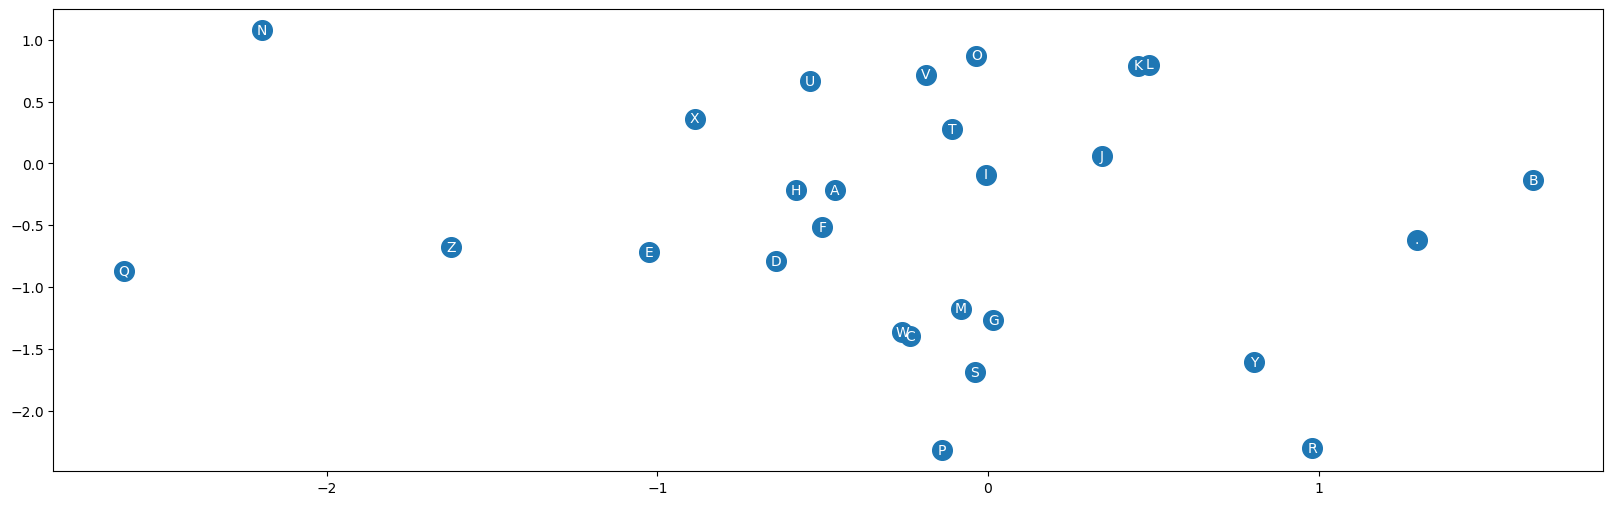

In [298]:
plt.figure(figsize=(20,6))
# plt.scatter(C[:,0].detach().numpy(), C[:,1].detach().numpy(), s=200)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(len(C)):
    plt.text(C[i,0].data, C[i,1].data, s=itos[i].upper(), ha="center", va="center", color='white')

In [302]:
h.shape

torch.Size([32, 100])

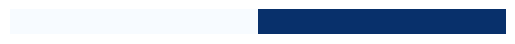

In [314]:
plt.imshow([[0,1]], cmap='Blues', aspect=0.1)
plt.axis('off');

In [389]:
# First forward pass for the model
idx = torch.randint(0, len(xs_train), (32,), generator=g)
# forward pass
hpreact = C[xs_train[idx]].view(-1,6) @ W1 + b1
h = torch.tanh(hpreact)

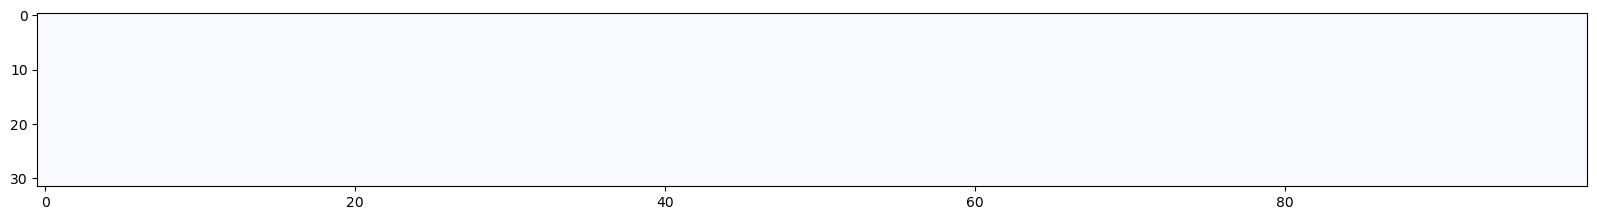

In [390]:
plt.figure(figsize=(20,6))
plt.imshow(h.abs() > 0.99, cmap='Blues', aspect=0.35) # Normalizes by default to the [1,0] interval

# I,J = h.shape
# for i in range(I):
#     for j in range(J):
#         plt.text(i, j, s=round(h[i, j].item(),2), ha='center', va='center')

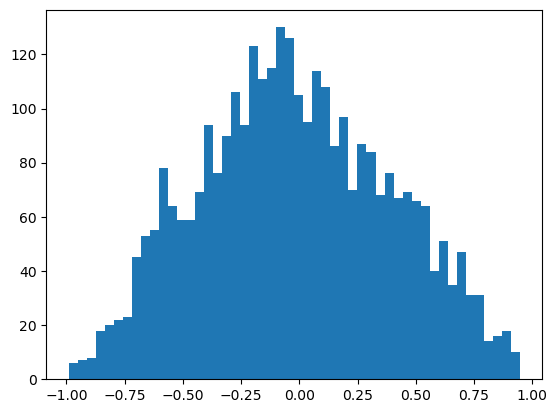

In [391]:
plt.hist(h.view(-1).tolist(), 50);

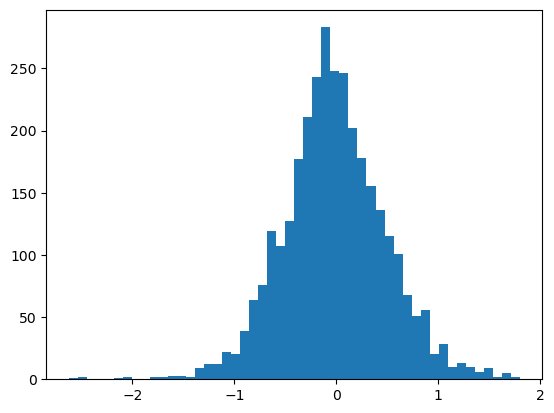

In [392]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [401]:
# Recalibrating initial weights for the layers in the Neural Network

C = torch.randn(27,2, generator=g) # char embedding
W1 = torch.randn(6, 100, generator=g) * 0.2 # Hidden layer with activation function tanh
b1 = torch.randn(100, generator=g) * 0.01

W2 = torch.randn(100, 27, generator=g) * 0.1 # Softmax layer
b2 = torch.randn(27, generator=g) * 0.01

parameters = [C, W1, b1, W2, b2]

total = 0
for m in parameters:
    total += m.nelement()

for p in parameters:
    p.requires_grad=True
    
print(f"Num. parameters: {total}")

Num. parameters: 3481


In [402]:
# First forward pass for the model
idx = torch.randint(0, len(xs_train), (32,), generator=g)
# forward pass
hpreact = C[xs_train[idx]].view(-1,6) @ W1 + b1
h = torch.tanh(hpreact)

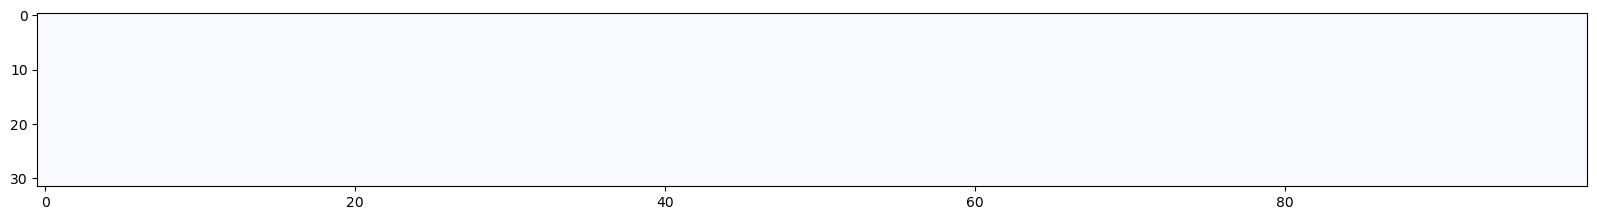

In [403]:
plt.figure(figsize=(20,6))
plt.imshow(h.abs() > 0.95, cmap='Blues', aspect=0.35) # Normalizes by default to the [1,0] interval

# I,J = h.shape
# for i in range(I):
#     for j in range(J):
#         plt.text(i, j, s=round(h[i, j].item(),2), ha='center', va='center')

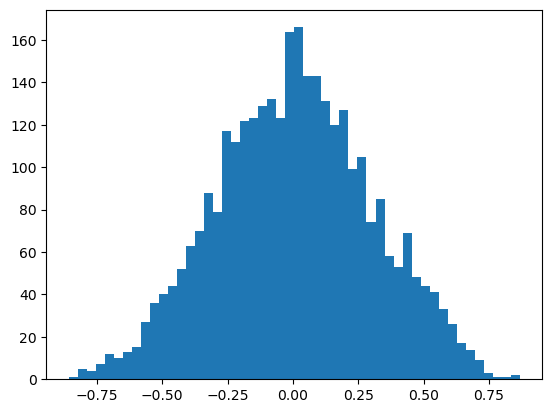

In [404]:
plt.hist(h.view(-1).tolist(), 50);

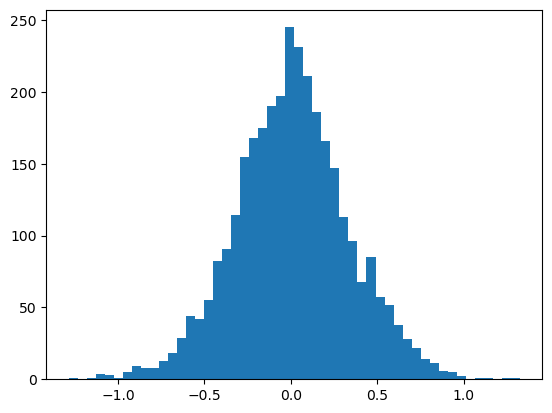

In [405]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [406]:
lossi = []

In [417]:
lr = 0.1 # learning rate param
for _ in range(10000):
    # Mini batch
    idx = torch.randint(0, len(xs_train), (32,), generator=g)
    
    # forward pass
    h = torch.tanh(C[xs_train[idx]].view(-1,6) @ W1 + b1)
    out = h @ W2 + b2
    
    loss = F.cross_entropy(out, ys_train[idx])
    
    # These two lines corresponds to the softmax column and the average log likelihood calculation --> Identical to using cross_entropy
    # probs = out.exp() / out.exp().sum(1, keepdims=True)
    # loss = -probs[torch.arange(32), ys[idx]].log().mean()
    
    lossi.append(loss.item())
    
    # set gradients to zero
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()
    
    # update data with gradients and learning rate
    for p in parameters:
        p.data += -lr * p.grad

print(lossi[-1])

2.3693268299102783


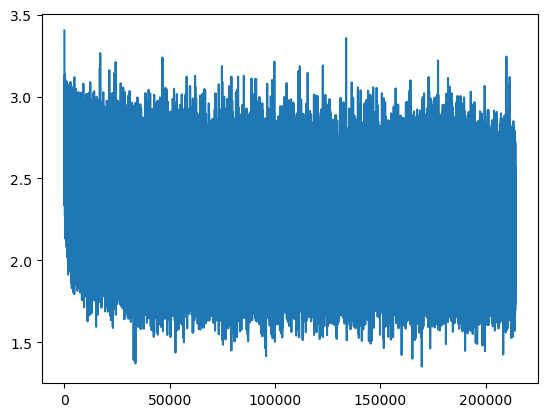

In [365]:
import matplotlib.pyplot as plt
plt.plot(lossi)

In [372]:
h.shape

torch.Size([1, 100])

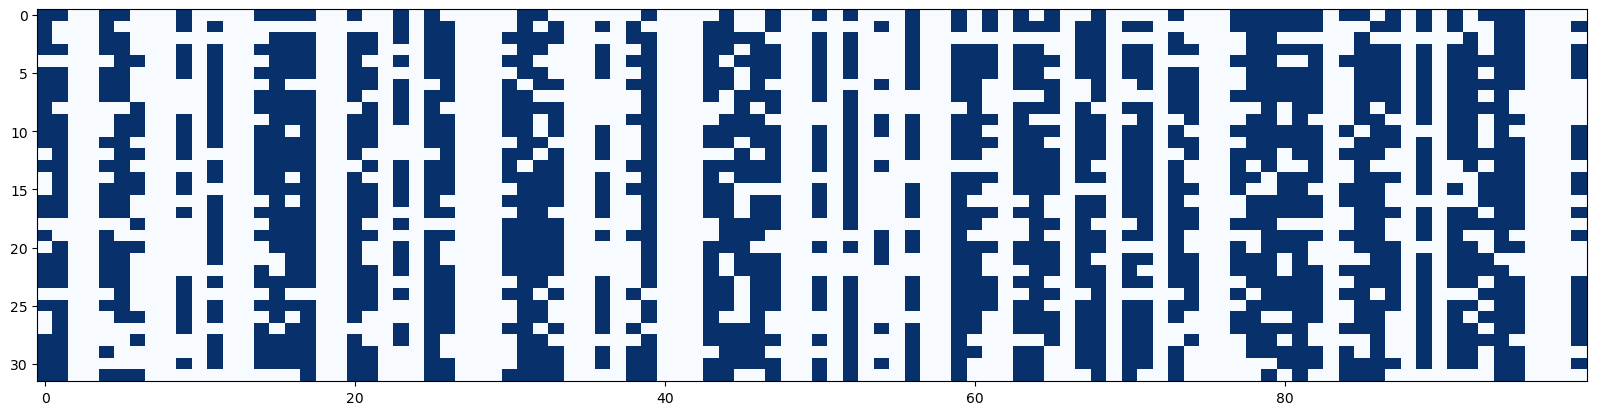

In [375]:
# Neurons that activated for the last training batch

plt.figure(figsize=(20,6))
plt.imshow(h.abs() > 0.95, cmap='Blues', aspect=0.75) # Normalizes by default to the [1,0] interval

In [366]:
# Evaluation set

# forward pass
h = torch.tanh(C[xs_dev].view(-1,6) @ W1 + b1)
out = h @ W2 + b2

eval = F.cross_entropy(out, ys_dev)
print(eval)

tensor(2.4380, grad_fn=<NllLossBackward0>)


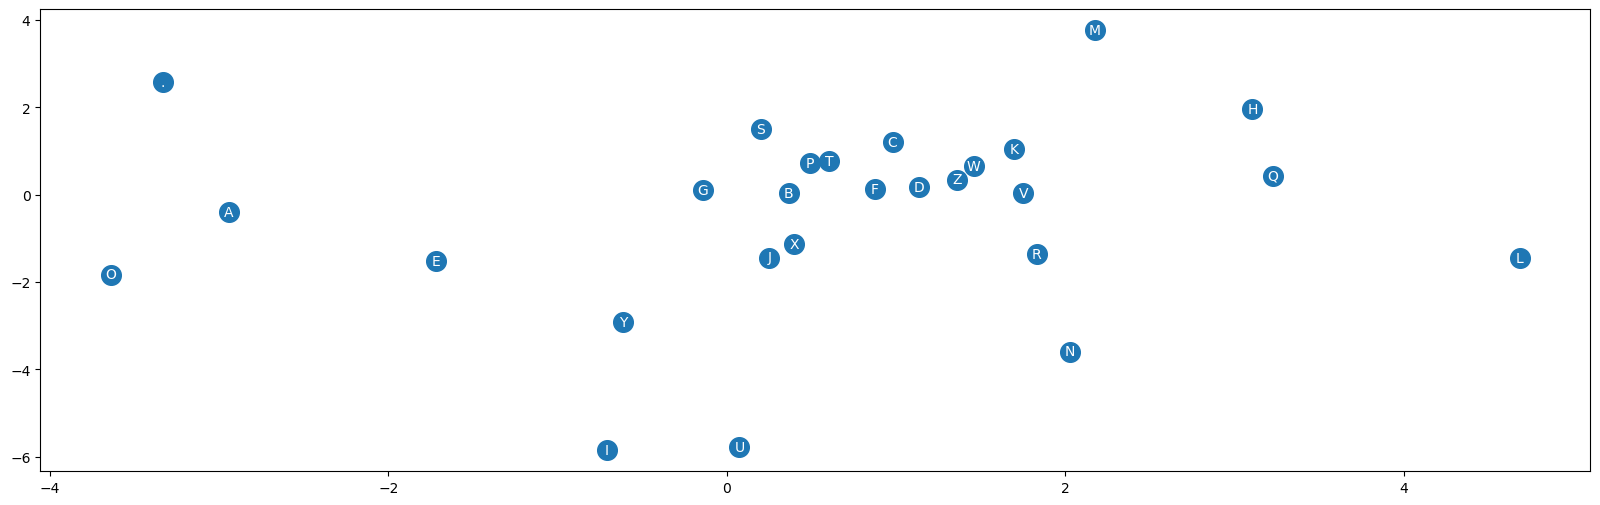

In [457]:
plt.figure(figsize=(20,6))
# plt.scatter(C[:,0].detach().numpy(), C[:,1].detach().numpy(), s=200)
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(len(C)):
    plt.text(C[i,0].data, C[i,1].data, s=itos[i].upper(), ha="center", va="center", color='white')

In [368]:
# Generating random names with Trigram model
block_size = 3
for _ in range(10):
    w = '.' * block_size
    
    while True:
        x = torch.tensor([stoi[ch] for ch in w[-3:]])
        
        # forward pass
        h = torch.tanh(C[x].view(-1,6) @ W1 + b1)
        out = h @ W2 + b2
        out = out.exp()
        probs = out / out.sum(1, keepdims=True)
        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        w += itos[idx]
        if itos[idx] == '.':
            break
    print(w.strip('.'))

koony
gleer
shiya
aill
naya
ardon
carercoo
kowtleeyahlila
sarine
elan


### Adding Batch Normalization to the previous Neural Network

In [464]:
# Recalibrating initial weights for the layers in the Neural Network

C = torch.randn(27,2, generator=g) # char embedding
W1 = torch.randn(6, 100, generator=g) / 6**0.5 # Hidden layer with activation function tanh
# b1 = torch.randn(100, generator=g) * 0.01

W2 = torch.randn(100, 27, generator=g) * 0.1 # Softmax layer
b2 = torch.randn(27, generator=g) * 0.01

bngain = torch.ones((1, 100))
bnbias = torch.zeros((1, 100))

bnmean_running = torch.ones((1, 100))
bnstd_running = torch.zeros((1, 100))

parameters = [C, W1, W2, b2, bngain, bnbias]

total = 0
for m in parameters:
    total += m.nelement()

for p in parameters:
    p.requires_grad=True
    
print(f"Num. parameters: {total}")

Num. parameters: 3681


In [483]:
lr = 0.1 # learning rate param
for i in range(1, 30001):
    # Mini batch
    idx = torch.randint(0, len(xs_train), (32,), generator=g)
    
    # forward pass
    hpreact = C[xs_train[idx]].view(-1,6) @ W1 # + b1 # As we are doing batch normalization, we dont need the bias, since we have the bnbias for adding biases to the layer. 
    bnmean_i = hpreact.mean(0, keepdim=True)
    bnstd_i = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean_i)/bnstd_i + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i
        
    h = torch.tanh(hpreact)
    # Softmax layer
    out = h @ W2 + b2
    loss = F.cross_entropy(out, ys_train[idx])
    
    # These two lines corresponds to the softmax column and the average log likelihood calculation --> Identical to using cross_entropy
    # probs = out.exp() / out.exp().sum(1, keepdims=True)
    # loss = -probs[torch.arange(32), ys[idx]].log().mean()
    
    lossi.append(loss.item())
    
    # set gradients to zero
    for p in parameters:
        p.grad = None
    
    # backpropagation
    loss.backward()
    
    # update data with gradients and learning rate
    for p in parameters:
        p.data += -lr * p.grad
    
    if i%1000 == 0:
        print(f"Loss: {lossi[-1]} \t({i} / 30000)")

Loss: 2.0428764820098877 	(1000 / 30000)
Loss: 2.61409068107605 	(2000 / 30000)
Loss: 2.4596261978149414 	(3000 / 30000)
Loss: 2.26619553565979 	(4000 / 30000)
Loss: 2.3628008365631104 	(5000 / 30000)
Loss: 2.6295225620269775 	(6000 / 30000)
Loss: 2.460745334625244 	(7000 / 30000)
Loss: 2.5937142372131348 	(8000 / 30000)
Loss: 1.9369937181472778 	(9000 / 30000)
Loss: 2.12300968170166 	(10000 / 30000)
Loss: 2.533339262008667 	(11000 / 30000)
Loss: 2.514267921447754 	(12000 / 30000)
Loss: 2.5110127925872803 	(13000 / 30000)
Loss: 2.4924774169921875 	(14000 / 30000)
Loss: 2.3564536571502686 	(15000 / 30000)
Loss: 2.5088438987731934 	(16000 / 30000)
Loss: 2.514127254486084 	(17000 / 30000)
Loss: 2.007293939590454 	(18000 / 30000)
Loss: 1.9708306789398193 	(19000 / 30000)
Loss: 2.09950852394104 	(20000 / 30000)
Loss: 2.1667001247406006 	(21000 / 30000)
Loss: 2.290848731994629 	(22000 / 30000)
Loss: 2.2786777019500732 	(23000 / 30000)
Loss: 2.4006032943725586 	(24000 / 30000)
Loss: 2.0738189

In [484]:
@torch.no_grad()
def eval(name='train'):
    x,y = {
        'train': (xs_train, ys_train),
        'dev': (xs_dev, ys_dev),
        'test': (xs_test, ys_test)
    }[name]
    
    hpreact = C[x].view(-1,6) @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y)


In [485]:
print(f"Loss in train set: {eval('train')}")
print(f"Loss in dev set: {eval('dev')}")
print(f"Loss in test set: {eval('test')}")

Loss in train set: 2.231147289276123
Loss in dev set: 2.52123761177063
Loss in test set: 2.543124198913574
